In [1]:
import scipy
import numpy as np
import numpy.linalg as LA

%matplotlib inline
import pylab
import matplotlib.pyplot as plt
from sklearn import neighbors
import pdb


# 数据加载

In [202]:
import scipy.io as sio

def load_Yale_data(randomsplit):
    #matlab文件名
    matfn=u'face_data/Yale/Yale_32x32.mat'
    data=sio.loadmat(matfn)
    face = data['fea']
    label = data['gnd'] - 1 ### python 从0 开始
    face = face  / 255.0

    #### 显示第一张图像
#     f1 = face[5].reshape((32,32)).T
#     pylab.imshow(f1, cmap=plt.cm.gray), pylab.show()

    ###  p = 6, randomsplit = 1
    matfn = u'face_data/Yale/6Train/'+str(randomsplit)+'.mat'
    index = sio.loadmat(matfn)
    testIdx = index['testIdx'] -1    ### python 从0 开始
    trainIdx = index['trainIdx'] -1  ### python 从0 开始

    train_face = face[trainIdx]
    test_face = face[testIdx]
    train_face = np.squeeze(train_face)  ## 将维度为1去掉
    test_face = np.squeeze(test_face)    ## 将维度为1去掉
    train_face = train_face.T ### 将数据维度变为: 样本维度 x 样本个数
    test_face = test_face.T ### 将数据维度变为: 样本维度 x 样本个数
    train_label = np.squeeze(label[trainIdx])
    test_label = np.squeeze(label[testIdx])
    return train_face, test_face, train_label, test_label

def load_ORL_data(randomsplit):
    #matlab文件名
    matfn=u'face_data/ORL/ORL_32x32.mat'
    data=sio.loadmat(matfn)
    face = data['fea']
    label = data['gnd'] - 1 ### python 从0 开始
    face = face  / 255.0

    #### 显示第一张图像
#     f1 = face[5].reshape((32,32)).T
#     pylab.imshow(f1, cmap=plt.cm.gray), pylab.show()

    ###  p = 6, randomsplit = 1
    matfn = u'face_data/ORL/6Train/'+str(randomsplit)+'.mat'
    index = sio.loadmat(matfn)
    testIdx = index['testIdx'] -1    ### python 从0 开始
    trainIdx = index['trainIdx'] -1  ### python 从0 开始

    train_face = face[trainIdx]
    test_face = face[testIdx]
    train_face = np.squeeze(train_face)  ## 将维度为1去掉
    test_face = np.squeeze(test_face)    ## 将维度为1去掉
    train_face = train_face.T ### 将数据维度变为: 样本维度 x 样本个数
    test_face = test_face.T ### 将数据维度变为: 样本维度 x 样本个数
    train_label = np.squeeze(label[trainIdx])
    test_label = np.squeeze(label[testIdx])
    return train_face, test_face, train_label, test_label

# BaseLine

In [203]:
acc_list = []
for i in xrange(1,51):
    train_face, test_face, train_label, test_label = load_Yale_data(randomsplit=i)
    mn = np.mean(train_face, keepdims=True, axis=1)
    train_face = train_face - mn
    test_face = test_face - mn
    clf = neighbors.KNeighborsClassifier(algorithm='auto',n_neighbors=1, weights= 'distance')  
    clf.fit(train_face.T, train_label) 
    """测试准确率"""
    acc = np.float(sum(test_label==clf.predict(test_face.T))) / len(test_label)
    acc_list.append(acc)
print 100.0-np.mean(acc_list)*100, np.std(acc_list)*100

39.28 4.03724878819


# EigenFace

In [204]:
def PCA(data, K=2):  
    """
    data : M x N matrix (M dimensions, N samples)
    K: The final reduced dimension
    """
#     M, N = data.shape
#     mn = np.mean(data, keepdims=True, axis=1)
# #     data = data - mn
#     covariance = np.matmul(data, np.transpose(data)) / (N-1)
#     eigenValues, eigenVectors = LA.eig(covariance)
#     eigValInd=np.argsort(eigenValues)
#     eigValInd=eigValInd[::-1][0:K]
#     principalEigVects=eigenVectors[:,eigValInd]
#     lowDimData=np.matmul(np.transpose(data), principalEigVects)
    M, N = data.shape
    mn = np.mean(data, keepdims=True, axis=1)
#     data = data - mn
#     print data.shape
    U, S, V = LA.svd(data, full_matrices=True)
    principalEigVects= np.transpose(U)[0:K,:]
    
    return principalEigVects.T

In [205]:
acc_list = []
for i in xrange(1,51):
    train_face, test_face, train_label, test_label = load_Yale_data(randomsplit=i)
    mn = np.mean(train_face, keepdims=True, axis=1)
    train_face = train_face - mn
    test_face = test_face - mn
    Eigen_faces = PCA(train_face, K=32)
    ##train数据
    lowDim_TrainData = np.matmul(Eigen_faces.T, train_face)
    ##test数据
    lowDim_TestData = np.matmul(Eigen_faces.T, test_face)
    clf = neighbors.KNeighborsClassifier(algorithm='auto',n_neighbors=1, weights= 'distance')  
    clf.fit(lowDim_TrainData.T, train_label) 
    """测试准确率"""
    acc = np.float(sum(test_label==clf.predict(lowDim_TestData.T))) / len(test_label)
    acc_list.append(acc)
print 100.0-np.mean(acc_list)*100, np.std(acc_list)*100

39.92 4.5208455453


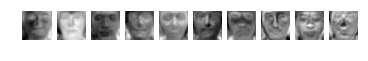

In [206]:
###保存Eigenfaces的图像
n_row = 10  ###显示多少张图像
fig = pylab.figure()
for i in range(n_row):
    p = Eigen_faces[:,i].reshape((32,32)).T
    fig.add_subplot(1, n_row, i+1)
    pylab.imshow(p, cmap=plt.cm.gray)
    pylab.axis('off') 
pylab.show()   
fig.savefig('Eigenfaces.png')

# FisherFace

In [209]:
def get_SB(data, label):  ### Get the between-class scatter matrix
    """
    data : M x N matrix (M dimensions, N samples)
    label: The label
    """
    M, N = data.shape
    mu = np.mean(data, keepdims=True, axis=1)  ### 全部样本数据的均值
    C = label.max() + 1  ### label的个数
    S_B = np.zeros((M, M)) ### 类间散度矩阵
    for i in xrange(C):
        i_index_list = [ind for ind, x in enumerate(label) if x == i]  ### 第i类label对应的下标
        data_i = data[:,i_index_list]  ### 第i类样本数据
        mu_i = np.mean(data_i, keepdims=True, axis=1)  ### 第i类样本数据的均值

        N_i= len(i_index_list)  ### 第i类样本数据的数量
        Sb_i = N_i * np.matmul((mu_i-mu), (mu_i-mu).T)
        S_B = S_B + Sb_i
    return S_B

def get_SW(data, label): ### Get the within-class scatter matrix
    """
    data : M x N matrix (M dimensions, N samples)
    label: The label
    """
    M, N = data.shape
    C = label.max() + 1  ### 类的个数
    S_W = np.zeros((M, M)) ### 类内散度矩阵
    for i in xrange(C):
        i_index_list = [ind for ind, x in enumerate(label) if x == i]  ### 第i类label对应的下标
        data_i = data[:,i_index_list]  ### 第i类样本数据
        mu_i = np.mean(data_i, keepdims=True, axis=1)  ### 第i类样本数据的均值
        Sw_i = np.matmul((data_i - mu_i), (data_i - mu_i).T)
        S_W = S_W + Sw_i
    return S_W

def LDA(data, label, K=14):
    S_B = get_SB(data, label)
    S_W = get_SW(data, label)
    N = len(label) ### 样本数量
    C = label.max() + 1  ### 类的个数
    
    #### 先执行PCA将原始数据的维度降到(N-C)维，用以解决S_W的奇异性问题####
    S_T = S_W + S_B
    eigenValues, eigenVectors = LA.eig(S_T)
    eigValInd = np.argsort(eigenValues)
    eigValInd = eigValInd[::-1][0:(N-C)]
    W_pca = eigenVectors[:,eigValInd]
    
    ##### 再执行FLD过程#######
    S_B_bar = np.matmul(np.matmul(W_pca.T, S_B), W_pca)
    S_W_bar = np.matmul(np.matmul(W_pca.T, S_W), W_pca)
    eigenValues, eigenVectors = LA.eig(np.matmul(LA.inv(S_W_bar), S_B_bar))

    eigValInd = np.argsort(eigenValues)
    eigValInd = eigValInd[::-1][0:K]
    W_fld = eigenVectors[:,eigValInd]
    
    #### 得到最优 W ###
    W_opt = np.matmul(W_pca, W_fld)
    return W_opt

In [201]:
train_face, test_face, train_label, test_label = load_Yale_data(randomsplit=5)
Fisherfaces = LDA(train_face, train_label, K=14).real

In [197]:
Fisherfaces.shape

(1024, 14)

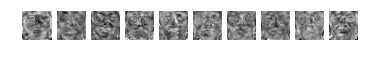

In [210]:
###保存Fisherfaces的图像
n_row = 10  ###显示多少张图像
fig = pylab.figure()
for i in range(n_row):
    p = Fisherfaces[:,i].reshape((32,32)).T
    fig.add_subplot(1, n_row, i+1)
    pylab.imshow(p, cmap=plt.cm.gray)
    pylab.axis('off') 
pylab.show()   
fig.savefig('Fisherfaces.png')

In [211]:
acc_list = []
for i in xrange(1,51):
    train_face, test_face, train_label, test_label = load_Yale_data(randomsplit=i)
    mn = np.mean(train_face, keepdims=True, axis=1)
    train_face = train_face - mn
    test_face = test_face - mn
    Fisherfaces = LDA(train_face, train_label, K=14)
    ##对train数据进行LDA降维
    lowDim_TrainData = np.matmul(Fisherfaces.T, train_face)
    ##对test数据进行LDA降维
    lowDim_TestData = np.matmul(Fisherfaces.T, test_face)
    clf = neighbors.KNeighborsClassifier(algorithm='auto',n_neighbors=1, weights= 'distance')  
    clf.fit(lowDim_TrainData.T, train_label) 
    """测试准确率"""
    acc = np.float(sum(test_label==clf.predict(lowDim_TestData.T))) / len(test_label)
    acc_list.append(acc)
print 100.0-np.mean(acc_list)*100, np.std(acc_list)*100

22.4533333333 4.09105256763


In [187]:
train_face, test_face, train_label, test_label = load_Yale_data(randomsplit=5)
mn = np.mean(train_face, keepdims=True, axis=1)
train_face = train_face - mn
test_face = test_face - mn
Fisherfaces = LDA(train_face, train_label, K=14)
##对train数据进行LDA降维
lowDim_TrainData = np.matmul(Fisherfaces.T, train_face)
##对test数据进行LDA降维
lowDim_TestData = np.matmul(Fisherfaces.T, test_face)
clf = neighbors.KNeighborsClassifier(algorithm='auto',n_neighbors=1, weights= 'distance')  
clf.fit(lowDim_TrainData.T, train_label) 
"""测试准确率"""
acc = np.float(sum(test_label==clf.predict(lowDim_TestData.T))) / len(test_label)
print acc

0.8
